## Heat equation

$$ \frac{\partial T}{\partial t} = d\cdot \frac{\partial^2 T}{x^2} + S(x,t) \newline$$
$$ T(0,t) = \alpha_0 (t) \newline$$
$$ T(L,t) = \alpha_L (t)\newline$$
$$ T(x,0) = \beta (x)\newline$$

In [1]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.utils.extmath import randomized_svd

In [21]:
#Parameters for the heat equation
N = 100
w = np.zeros(N)
L = 10
h = L / (N+1)
d = 0.1
steps = 40_000
dt = 0.02

$$ w` = A \cdot w + b(t) $$

In [22]:
#Calculating A matrix 
A = np.diag([-2]*N)+np.diag([1]*(N-1),1)+np.diag([1]*(N-1),-1)
A = A*d/h/h # d h**2
A

array([[-20.402,  10.201,   0.   , ...,   0.   ,   0.   ,   0.   ],
       [ 10.201, -20.402,  10.201, ...,   0.   ,   0.   ,   0.   ],
       [  0.   ,  10.201, -20.402, ...,   0.   ,   0.   ,   0.   ],
       ...,
       [  0.   ,   0.   ,   0.   , ..., -20.402,  10.201,   0.   ],
       [  0.   ,   0.   ,   0.   , ...,  10.201, -20.402,  10.201],
       [  0.   ,   0.   ,   0.   , ...,   0.   ,  10.201, -20.402]])

In [23]:
A.shape

(100, 100)

In [24]:
# Initial and boundary conditions

#Source
def S(x, t):
    return np.exp( -(x-L/2)**2 / L/2) + 1/(t+1)
#    return 0

def alpha0( t ):
    return 20 + 100 * np.sin( t / 100 )
    
def alphaL( t ):
    return 100 + 100 * np.cos( t / 100 )

def beta( x ):
    return 300

#Right side of 𝑤‘=𝐴⋅𝑤+𝑏(𝑡)
def b(t):
    ret = [ S((i+1)*h, t) for i in range(N)]
    ret[0] += d*alpha0(t)/h/h
    ret[-1] += d*alphaL(t)/h/h
    return ret

def F(w, t):
    return (np.dot(A,w))+b(t)

In [25]:
#Explicit Euler
w0 = np.array([ beta( (i+1)*h ) for i in range(N) ])

X = np.zeros((steps+1,N))
X[0] = w0
for ts in range(steps):
    X[ts+1] = dt*F(X[ts], ts*dt) + X[ts]

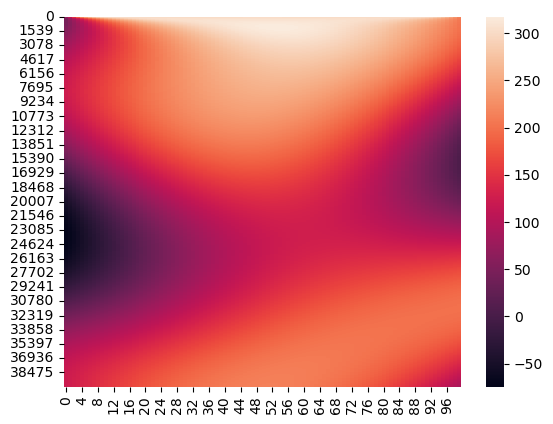

In [26]:
sns.heatmap(X)
plt.show()

# Project

### Reduce equation

$$ \alpha´ = A_r \cdot \alpha + b_r \\ \alpha_0 = U_r^T \dot w_0 $$

$$ A_r = U_r^T\cdot A \cdot U_r $$

$$ b_r(t) = U_r^T \cdot b(t) $$

## Reducing the source and heat equation

### Reducing the source


- Because the source doesn´t depend of the state of the heat in the previus step, 
- it is possible to calculate the source heat independly 
- Here im creating the matrix for the source in position and time

In [27]:
Source_m = np.array([b(ts*dt) for ts in range(steps+1)])
Source_m

array([[2.05320898e+02, 1.31570385e+00, 1.33091409e+00, ...,
        1.33091409e+00, 1.31570385e+00, 2.04150090e+03],
       [2.05505310e+02, 1.29609601e+00, 1.31130625e+00, ...,
        1.31130625e+00, 1.29609601e+00, 2.04148127e+03],
       [2.05690476e+02, 1.27724231e+00, 1.29245255e+00, ...,
        1.29245255e+00, 1.27724231e+00, 2.04146235e+03],
       ...,
       [1.21362578e+03, 3.16952351e-01, 3.32162593e-01, ...,
        3.32162593e-01, 3.16952351e-01, 8.72381271e+02],
       [1.21359616e+03, 3.16952320e-01, 3.32162562e-01, ...,
        3.32162562e-01, 3.16952320e-01, 8.72179413e+02],
       [1.21356649e+03, 3.16952289e-01, 3.32162531e-01, ...,
        3.32162531e-01, 3.16952289e-01, 8.71977562e+02]])

In [28]:
Source_m.shape

(40001, 100)

- Compute the SVD for the heat eq
- And now for the heat source in each time step, compute $ b_r(t) = U_r^T \cdot b(t) $ to reduce the source

In [29]:
comp = 4
# Single Value Decomposition for the heat eq
U,s,Vh = randomized_svd(X.T,n_components=comp,random_state=0)

Source_m_red = np.array([U.T @ source_ts for source_ts in Source_m])

In [30]:
Source_m_red.shape

(40001, 4)

- The source is now reduced.

### Reducing the Heat eq

In [31]:
# Single Value Decomposition
U,s,Vh = randomized_svd(X.T,n_components=comp,random_state=0)

#Compose Ar matrix
Ar = U.T @ A @ U
Ar

array([[-0.06445376, -0.10544729, -0.18321865, -0.08567008],
       [-0.10544729, -0.64429409,  0.05298951,  0.60002923],
       [-0.18321865,  0.05298951, -1.01145212, -1.0295829 ],
       [-0.08567008,  0.60002923, -1.0295829 , -1.72597689]])

In [32]:
#Compose br function
def br(t):
    return  Source_m_red[t] # Source_m_red has the heat source already reduced

def Fr(w, t):
    return (np.dot(Ar,w))+br(t)

### Explicit Euler

In [33]:
# w0 = np.array([ beta( (i+1)*h ) for i in range(N) ])
wr0 = U.T@w0

Xr = np.zeros((steps+1,4))
Xr[0] = wr0
for ts in range(steps):
    Xr[ts+1] = dt*Fr(Xr[ts], ts) + Xr[ts]

In [34]:
Xred=U@Xr.T

<Axes: >

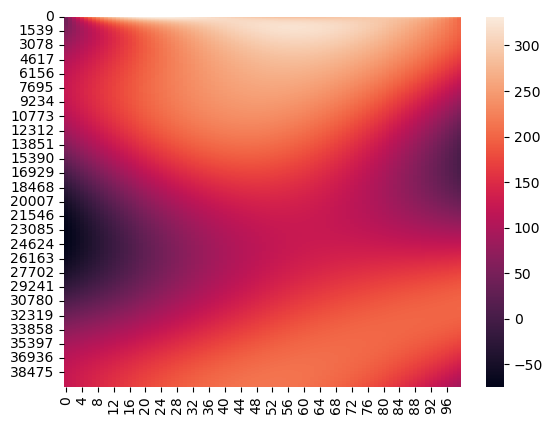

In [35]:
sns.heatmap(Xred.T)

- As you can see, the result is really similar at the one without reduction

### Comparing the error

<Axes: >

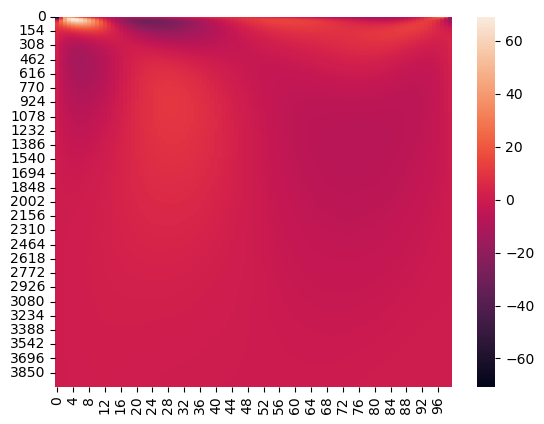

In [43]:
sns.heatmap(X[:4000] - Xred.T[:4000])